In [1]:
import cupy as cp

# check if CuPy was installed and print out the nr. of available GPUs
num_gpus = cp.cuda.runtime.getDeviceCount()

print(f"Number of GPUs detected: {num_gpus}")

Number of GPUs detected: 2


# Julia set

The Julia set is generated by the iterative equation:

$$
z_{n+1}=z^{2}_{n}+c
$$

with c being a complex constant $(-0.7,0.27015i)$ in the present case. 

/scratch/ipykernel_342388/220777492.py:26: RuntimeWarning: overflow encountered in multiply
  z = z * z + c  # Update z with the Julia iteration equation
/scratch/ipykernel_342388/220777492.py:26: RuntimeWarning: invalid value encountered in multiply
  z = z * z + c  # Update z with the Julia iteration equation


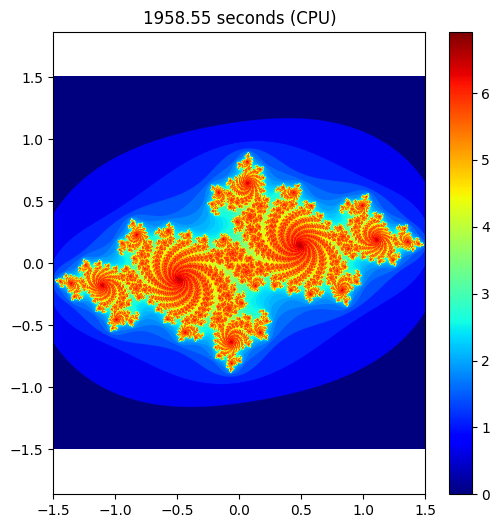

Total CPU Time: 1958.55 seconds


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def juliacpu(c, grid_size=1000, max_iterations=1000):
    # Define the limits for the x and y axes 
    xlim = [-1.5, 1.5]
    ylim = [-1.5, 1.5]
    
    # Start execution timing
    start_time = time.time()
    
    # Generate linearly spaced values for x and y
    x = np.linspace(xlim[0], xlim[1], grid_size)
    y = np.linspace(ylim[0], ylim[1], grid_size)
    
    # Create a grid of complex numbers (x + iy)
    x_grid, y_grid = np.meshgrid(x, y)
    z = x_grid + 1j * y_grid  # Initialize z to the grid points in the complex plane
    
    # Initialize the count array
    count = np.ones(z.shape, dtype=np.float32)
    
    # Julia set computation
    for n in range(max_iterations):
        z = z * z + c  # Update z with the iteration equation above
        inside = np.abs(z) <= 2  # Check if the point is inside the boundary
        count += inside  # Increment the count for points that remain bounded
    
    # Use log to the counts for better visualization
    count = np.log(count)
    
    # Stop execution timing
    cpu_time = time.time() - start_time
    
    # Plot the result
    plt.figure(figsize=(6, 6))
    plt.imshow(count, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='jet')
    plt.colorbar()
    plt.axis('equal')
    plt.title(f'{cpu_time:.2f} seconds (CPU)')
    
    # Save the figure to a file
    plt.savefig('out-julia.png')
    plt.show()
    
    return cpu_time

# Julia set CPU function for a given complex constant c
c = complex(-0.7, 0.27015)
cpu_time = juliacpu(c, grid_size=20000, max_iterations=1000)
print(f"Total CPU Time: {cpu_time:.2f} seconds")


## single GPU

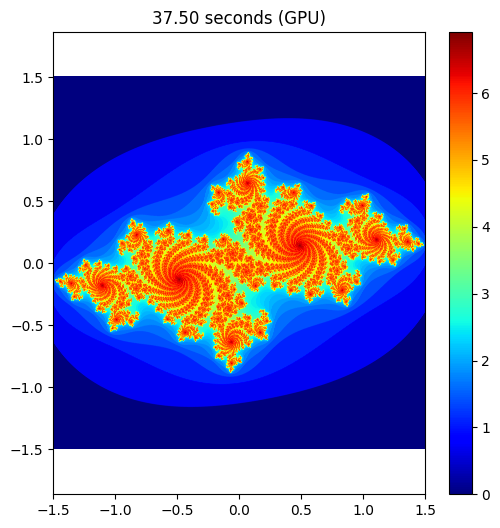

Total GPU Time: 37.50 seconds


In [2]:
import cupy as cp  # CuPy for GPU support
import matplotlib.pyplot as plt
import time

def juliagpu(c, grid_size=1000, max_iterations=1000):
    # Define the limits for the x and y axes (view window)
    xlim = [-1.5, 1.5]
    ylim = [-1.5, 1.5]
    
    # Start timing 
    start_time = time.time()
    
    # Generate linearly spaced values for x and y using CuPy (GPU)
    x = cp.linspace(xlim[0], xlim[1], grid_size)
    y = cp.linspace(ylim[0], ylim[1], grid_size)
    
    # Create a grid of complex numbers (x + iy) on the GPU
    x_grid, y_grid = cp.meshgrid(x, y)
    z = cp.array(x_grid + 1j * y_grid, dtype=cp.complex64)  # Initialize z on GPU
    
    # Initialize the count array on the GPU
    count = cp.ones(z.shape, dtype=cp.float32)
    
    # Julia set computation
    for n in range(max_iterations):
        z = z * z + c  # Update z with the Julia iteration equation
        inside = cp.abs(z) <= 2  # Are points are inside the boundary
        count += inside  # Increment the count for points that remain bounded
    
    # using log to the counts for better visualization
    count = cp.log(count)
    
    # fetch data back from the GPU (move to CPU using CuPy's `asnumpy`)
    count_cpu = cp.asnumpy(count)
    
    # Stop timing 
    gpu_time = time.time() - start_time
    
    # Plot the result
    plt.figure(figsize=(6, 6))
    plt.imshow(count_cpu, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='jet')
    plt.colorbar()
    plt.axis('equal')
    plt.title(f'{gpu_time:.2f} seconds (GPU)')
    
    # Save the figure to a file
    plt.savefig('out-julia-gpu.png')
    plt.show()
    
    return gpu_time

# Julia set GPU function for a given complex constant c
c = complex(-0.7, 0.27015)  
gpu_time = juliagpu(c, grid_size=20000, max_iterations=1000)
print(f"Total GPU Time: {gpu_time:.2f} seconds")

## multi GPU

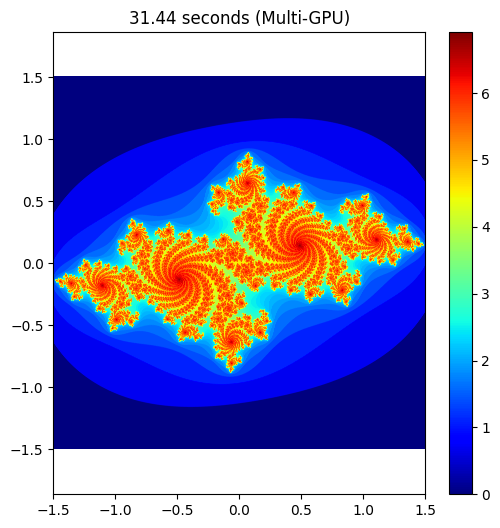

Total GPU Time (Multi-GPU): 31.44 seconds


In [6]:
import cupy as cp  # CuPy for GPU support
import numpy as np
import matplotlib.pyplot as plt
import time

def juliagpu_multi(c, grid_size=1000, max_iterations=1000, num_gpus=2):
    # Define the limits for the x and y axes (view window)
    xlim = [-1.5, 1.5] 
    ylim = [-1.5, 1.5]

    # Start timing the GPU execution
    start_time = time.time()

    # Generate linearly spaced values for x and y
    x = np.linspace(xlim[0], xlim[1], grid_size)  #  this array is on CPU
    y = np.linspace(ylim[0], ylim[1], grid_size)  #  this array is on CPU

    # Split the y axis into chunks for each GPU
    y_chunks = np.array_split(y, num_gpus)  # using NumPy to split, not CuPy

    results = []  # List to hold results from each GPU
    streams = []  # List of streams for asynchronous GPU operations

    # Iterate over each GPU
    for i in range(num_gpus):
        with cp.cuda.Device(i):  # Assign computation to a specific GPU
            stream = cp.cuda.Stream()  # Create a stream for asynchronous execution
            streams.append(stream)

            with stream:
                # Create a grid of complex numbers (x + iy) for this GPU chunk
                x_gpu = cp.asarray(x)  # Move x to GPU
                y_chunk_gpu = cp.asarray(y_chunks[i])  # Move y chunk to GPU
                x_grid, y_grid = cp.meshgrid(x_gpu, y_chunk_gpu)  # Ensure chunk uses CuPy array
                z = cp.array(x_grid + 1j * y_grid, dtype=cp.complex64)

                # Initialize the count array on the GPU
                count = cp.ones(z.shape, dtype=cp.float32)

                # Julia set computation
                for n in range(max_iterations):
                    z = z * z + c  # Update z with the Julia iteration equation
                    inside = cp.abs(z) <= 2  # Check which points are inside the boundary
                    count += inside  # Increment the count for points that remain bounded

                # Apply log to the counts for better visualization
                count = cp.log(count)

                results.append(count)  # Append the result of this GPU's chunk to the results

    # Synchronize all GPUs to make sure the computations are done
    for stream in streams:
        stream.synchronize()

    # Concatenate the results from all GPUs along the y-axis
    with cp.cuda.Device(0):  # Move to the default device for concatenation
        count_total = cp.concatenate([res for res in results], axis=0)

    # Fetch data back from the GPU (move to CPU using CuPy's `asnumpy`)
    count_cpu = cp.asnumpy(count_total)

    # Stop timing the GPU execution
    gpu_time = time.time() - start_time

    # Plot the result
    plt.figure(figsize=(6, 6))
    plt.imshow(count_cpu, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='jet')
    plt.colorbar()
    plt.axis('equal')
    plt.title(f'{gpu_time:.2f} seconds (Multi-GPU)')
    
    # Save the figure to a file
    plt.savefig('out-julia-multi-gpu.png')
    plt.show()

    return gpu_time

# Example: Run the Julia set multi-GPU function for a given complex constant c
c = complex(-0.7, 0.27015)  # You can change this value for different Julia sets
gpu_time = juliagpu_multi(c, grid_size=20000, max_iterations=1000, num_gpus=2)
print(f"Total GPU Time (Multi-GPU): {gpu_time:.2f} seconds")